### Instructions
This notebook runs all the modelling and saves them as pickle files
IMPORTANT: Make sure you have pandas >= 1.5.0 in order to read in the pickle files

1. Run first cell and function definition cells

In [47]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb

features_all = pd.read_csv('features_all_weeks.csv')
features_all.drop(columns = ['Unnamed: 0', 'X1', 'X'], inplace = True)
# display(features_all)
print(features_all.info())

unclean_train_df = features_all[features_all['week'] != 8]
unclean_test_df = features_all[features_all['week'] == 8]

unclean_train_df.drop(columns = ['week'], inplace = True)
unclean_test_df.drop(columns = ['week'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200118 entries, 0 to 200117
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   playId                 200118 non-null  int64  
 1   gameId                 200118 non-null  int64  
 2   frameId                200118 non-null  int64  
 3   area_block             200118 non-null  float64
 4   dist_block             200118 non-null  float64
 5   dist_to_qb_block       200118 non-null  float64
 6   x_force_block          200118 non-null  float64
 7   y_force_block          200118 non-null  float64
 8   norm_weighted_x_block  200118 non-null  float64
 9   norm_weighted_y_block  200118 non-null  float64
 10  area_rush              200118 non-null  float64
 11  dist_rush              200118 non-null  float64
 12  dist_to_qb_rush        200118 non-null  float64
 13  x_force_rush           200118 non-null  float64
 14  y_force_rush           200118 non-nu

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
def get_features(df, features = 'all', response = 'bad_thing'):
    """
    Gets relevant features depending on what we want to use for modelling.
    There are 2 types of features: distance features and force features. 
    Force features can also be decomposed to simple forces, weighted forces, and partitioned forces
    TODO: missing net forces
    """
    y = df['bad_thing']
    x = df.drop(columns = ['bad_thing', 'hit', 'hurry', 'sack', 'playId', 'gameId', 'frameId'])
    if features == 'all':
        return (x, y)
    elif features == 'distance':
        x = x[['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush']]
    
    elif features == 'force_simple':
        x = x[['x_force_block', 'y_force_block', 'x_force_rush', 'y_force_rush']]
    
    elif features == 'force_weighted':
        x = x[['norm_weighted_x_block', 'norm_weighted_y_block', 'norm_weighted_x_rush', 'norm_weighted_y_rush']]
    
    elif features == 'force_partitioned':
        x = x[['net_x_force_bottom', 'net_y_force_bottom', 'net_x_force_middle', 'net_y_force_middle', 
               'net_x_force_top', 'net_y_force_top']]
    elif features == 'force_all':
        x = x.drop(columns = ['area_block', 'dist_block', 'dist_to_qb_block', 'area_rush', 'dist_rush', 'dist_to_qb_rush'])
    
    return (x, y)

# keep track of frameID
def df_split_by_frame(df, group_by = 5, features = 'all'):
    """
    Helper function to get separate dataframes for each frameID. Also keeps track of which set of features we're using
    for naming the model later on
    """
    df_grouped = df.groupby('frameId')
    df_dict = dict()

    for n, df in df_grouped:
        if (n % group_by == 1 and n < 60):
            x, y = get_features(df, features)
            # display(x)
            df_dict[n] = (x, y, features)
            # df_list.append((n, x, y))
    return df_dict

In [54]:

def train_rf_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123456, max_depth = 15)
        rf.fit(x, y)
        models[frameID] = (rf, features_str)
        del rf
    pickle.dump(models, open(f"model_list_rf_{features_str}.pkl", "wb"))
    return models

def train_xgboost_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        print(frameID)
        xgboost = xgb.XGBClassifier(max_depth=5, n_estimators=30,objective='binary:logistic')
        xgboost.fit(x, y)
        models[frameID] = (xgboost, features_str)
        del xgboost
    pickle.dump(models, open(f"model_list_xgboost_{features_str}.pkl", "wb"))
    return models

def train_lr_model(df_dict):
    models = dict()
    for (frameID, (x, y, features_str)) in df_dict.items():
        # TODO: change to LR model with intercept
        lr = sklearn.linear_model.LogisticRegression(fit_intercept=True)
        #fit intercept=Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
        lr.fit(x, y)
        models[frameID] = (lr, features_str)
        del lr
    pickle.dump(models, open(f"model_list_lr_{features_str}.pkl", "wb"))
    return models

def rf_xgboost_evaluate(test_df_dict, models,oob):
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        
        if oob==False:
            print(f'{frameID}: Out-of-bag score estimate: {model.oob_score_:.3}')
            
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        print(thresh)
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        
def lr_evaluate(test_df_dict, models):
    for frameID, (model, _) in models.items():
        x, y, _ = test_df_dict[frameID]
        pred = model.predict(x)
        pred_prob = model.predict_proba(x)[:, 1]
        lst1=np.array(pred_prob)
        pred=np.array(lst1>0.5).astype(int)
        accuracy = accuracy_score(y, pred)
        recall = recall_score(y, pred)
        
        print(f'{frameID}: Out-of-bag score estimate: {model.oob_score_:.3}')
        print(f'{frameID}: Mean accuracy score: {accuracy:.3}')
        print(f'{frameID}: Recall: {recall:.3}')
        
        fpr, tpr, _ = roc_curve(y, pred_prob)

        #create ROC curve
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        p, r, thresh = precision_recall_curve(y, pred_prob)
        print(thresh)
        fig, ax = plt.subplots()
        ax.plot(r, p, color='purple')

        #add axis labels to plot
        ax.set_title('Precision-Recall Curve')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')

        #display plot
        plt.show()
        


In [44]:
lst=[0.3,0.5,0.7]
res=[]
for item in lst:
    if item>0.5:
        res.append(1)
    else:
        res.append(0)
print(res)
lst1=np.array(lst)
res1=np.array(lst1>0.5).astype(int)
print(res1)
    


[0, 0, 1]
[0 0 1]


In [14]:
#features = 'distance'

#features = 'force_simple'
#features = 'force_weighted'
features = 'force_partitioned'



clean_train_df_dict = df_split_by_frame(unclean_train_df, features = features)
clean_test_df_dict = df_split_by_frame(unclean_test_df, features = features)

pickle.dump(clean_test_df_dict, open(f"clean_test_dict_{features}.pkl", "wb"))

models = train_rf_model(clean_train_df_dict)
# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

1
6
11
16
21
26
31
36
41
46
51
56


In [15]:
models_force_simple = pickle.load(open("model_list_rf_force_simple.pkl", "rb"))
clean_test_df_dict_force_simple = pickle.load(open("clean_test_dict_force_simple.pkl", "rb"))

#models_force_dist = pickle.load(open("model_list_rf_distance.pkl", "rb"))
#clean_test_df_dict_dist = pickle.load(open("clean_test_dict_distance.pkl", "rb"))

# models_all = pickle.load(open("model_list_all_features.pkl", "rb"))

1: Out-of-bag score estimate: 0.609
1: Mean accuracy score: 0.61
1: Recall: 0.0513


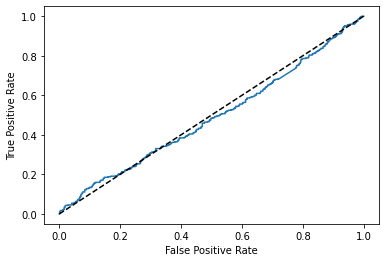

[0.2048156  0.20767583 0.2175177  0.22207462 0.22347004 0.22661669
 0.22945013 0.23069193 0.23190866 0.23510237 0.23517786 0.23596973
 0.23688386 0.24078606 0.24329442 0.24913169 0.24952459 0.25247373
 0.25283353 0.25382711 0.25404604 0.25681034 0.2598129  0.26021775
 0.26253889 0.26359367 0.26536792 0.26812433 0.26890286 0.26893395
 0.2694242  0.26943432 0.26949999 0.2710868  0.27213544 0.27409417
 0.27522828 0.27561399 0.27624847 0.27765868 0.27874795 0.27888633
 0.27892    0.2794122  0.27942019 0.27986896 0.28189136 0.28233037
 0.28265395 0.28274591 0.28361264 0.28411316 0.28455526 0.28467082
 0.28500342 0.28508123 0.28766166 0.28804144 0.28914731 0.28946147
 0.29064349 0.29133533 0.29172512 0.29184141 0.29226273 0.2925941
 0.29306998 0.29361043 0.29396668 0.29416054 0.29420949 0.29454479
 0.29478338 0.29497024 0.29570237 0.29579948 0.29627912 0.29655288
 0.29673816 0.29675748 0.29715958 0.29740586 0.29873881 0.29932068
 0.29953252 0.29970499 0.2998991  0.30154398 0.30174705 0.30252

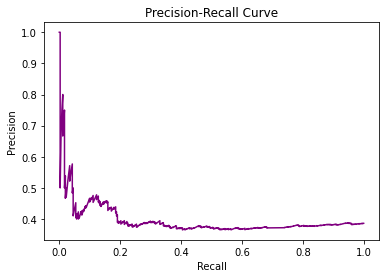

6: Out-of-bag score estimate: 0.611
6: Mean accuracy score: 0.613
6: Recall: 0.0458


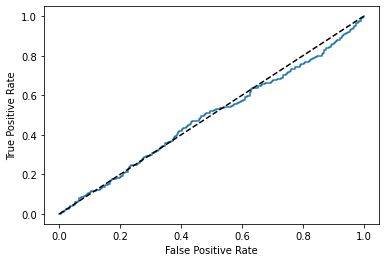

[0.1637784  0.18270644 0.18362603 0.18682921 0.1973786  0.19803338
 0.20563646 0.20770723 0.21022726 0.21794954 0.21828947 0.21927032
 0.21999636 0.22132587 0.22311786 0.22394715 0.22431632 0.22831917
 0.23022631 0.23056092 0.23344214 0.23351127 0.23416818 0.23467277
 0.23622831 0.2376629  0.23830473 0.24011024 0.24046529 0.24081314
 0.241335   0.24135539 0.24201888 0.24208013 0.24221019 0.24230888
 0.24294254 0.24350348 0.24366527 0.24564489 0.24662951 0.24695726
 0.24726322 0.24749584 0.25233929 0.25248383 0.25311993 0.25332572
 0.25392499 0.25400156 0.2541176  0.25427871 0.25438287 0.25493278
 0.25499756 0.25500152 0.25614768 0.25614849 0.25710178 0.25766955
 0.25793946 0.25879115 0.2589066  0.25897496 0.25997528 0.26075153
 0.26136204 0.26158736 0.26198567 0.26235813 0.26270428 0.26286587
 0.2629459  0.26490334 0.26491068 0.26502208 0.26572908 0.26656156
 0.2668282  0.26930154 0.27011594 0.2706533  0.27242686 0.27259402
 0.27306355 0.27320564 0.27328758 0.2734014  0.27435874 0.2748

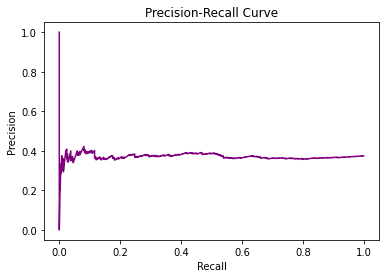

11: Out-of-bag score estimate: 0.603
11: Mean accuracy score: 0.61
11: Recall: 0.0738


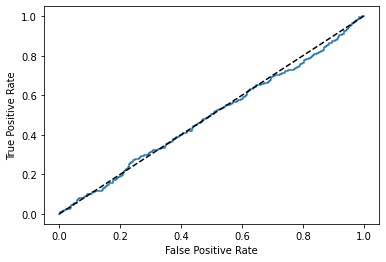

[0.23311175 0.23347597 0.23792181 0.23823786 0.238382   0.23844651
 0.23924536 0.23934034 0.23934487 0.24158335 0.24225525 0.24286717
 0.2430123  0.24425768 0.2454282  0.24589522 0.24885966 0.24916127
 0.24939888 0.25138594 0.2527731  0.25437915 0.25798105 0.25833515
 0.25852167 0.25955811 0.25965437 0.26404073 0.26409595 0.26437022
 0.26452635 0.26748492 0.26752322 0.26957983 0.27064389 0.27174507
 0.27205099 0.27323318 0.27411634 0.27417099 0.27594068 0.27694954
 0.27763185 0.2778336  0.27936822 0.2793897  0.27970405 0.28084176
 0.28113869 0.28165764 0.2824407  0.28263179 0.28276454 0.28292651
 0.2831602  0.28336345 0.28347191 0.28348891 0.28406366 0.28434937
 0.28538702 0.2861814  0.28642388 0.28765495 0.2879504  0.28837282
 0.28962494 0.29013818 0.29018435 0.29098702 0.29124982 0.29146272
 0.29153306 0.29216575 0.2922864  0.29243244 0.29265972 0.29271255
 0.29341325 0.29433283 0.29450291 0.29493003 0.29493473 0.29532754
 0.29558087 0.29597729 0.2961673  0.29626306 0.29680192 0.2970

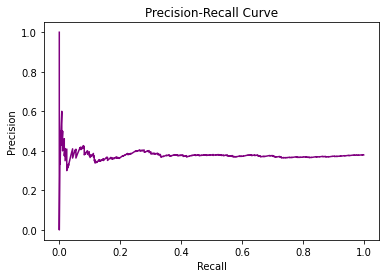

16: Out-of-bag score estimate: 0.605
16: Mean accuracy score: 0.601
16: Recall: 0.105


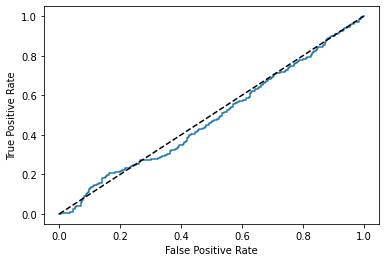

[0.1607979  0.176067   0.18952976 0.19133091 0.191594   0.19938139
 0.20407169 0.20449927 0.20483216 0.20497001 0.20852318 0.209299
 0.22040907 0.22223165 0.2226763  0.22663839 0.22765571 0.22942925
 0.22975441 0.23010021 0.23060104 0.23263383 0.23367557 0.23392792
 0.23408712 0.23434811 0.23572486 0.2361914  0.23662316 0.23804628
 0.2437591  0.24976018 0.25096517 0.2513266  0.25257831 0.25291389
 0.26013878 0.26162166 0.2616306  0.2616406  0.26245425 0.26367511
 0.2651612  0.26579293 0.26640022 0.26642879 0.266512   0.26700509
 0.26730817 0.26743167 0.26821426 0.26838014 0.26852658 0.2685574
 0.27025937 0.27026572 0.27047031 0.27174824 0.27385717 0.27393352
 0.27472559 0.27520962 0.27560949 0.27598464 0.2761061  0.27776928
 0.27839427 0.27850166 0.27906557 0.27938213 0.27949284 0.28126777
 0.2814612  0.28241208 0.28255086 0.28284484 0.28375786 0.28521813
 0.28526523 0.28566774 0.2858741  0.28605267 0.28677521 0.28776255
 0.2895816  0.29051024 0.29065333 0.29076942 0.29084877 0.2911293

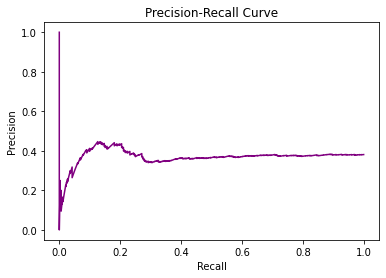

21: Out-of-bag score estimate: 0.595
21: Mean accuracy score: 0.595
21: Recall: 0.0788


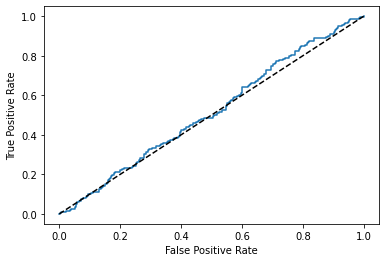

[0.1691233  0.19645602 0.1988536  0.20570872 0.20676356 0.21271925
 0.21687468 0.22254906 0.23078841 0.23107459 0.23124643 0.23146013
 0.2326816  0.23541586 0.23735154 0.24176126 0.24436401 0.24524722
 0.24564503 0.24811842 0.24939223 0.25048646 0.25065624 0.25122402
 0.25145926 0.25206123 0.25237415 0.25425415 0.25439471 0.2576912
 0.25836438 0.25970544 0.26081392 0.26142422 0.26227183 0.26348661
 0.26367182 0.2638977  0.26404143 0.26473273 0.26778707 0.26824554
 0.26895762 0.26983215 0.26995231 0.27236223 0.27253207 0.27278789
 0.27391345 0.27529131 0.27584067 0.2760451  0.27617617 0.27787406
 0.27788726 0.27865286 0.27993517 0.2806905  0.28204432 0.28241934
 0.2831858  0.283865   0.28389167 0.28542002 0.2870807  0.28715933
 0.28850608 0.2887468  0.29025615 0.29094105 0.29168588 0.29169365
 0.29182914 0.29209779 0.29224818 0.29265911 0.29312125 0.29438185
 0.29479385 0.29516291 0.29550299 0.29714199 0.29722422 0.29826166
 0.29871835 0.29895837 0.29919294 0.2996134  0.30039926 0.30075

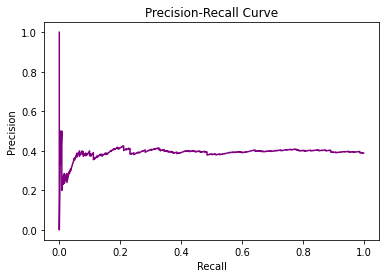

26: Out-of-bag score estimate: 0.555
26: Mean accuracy score: 0.583
26: Recall: 0.19


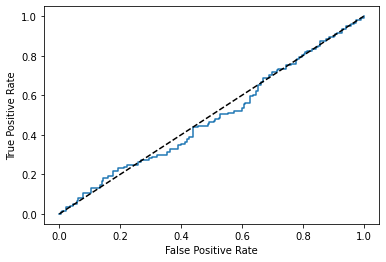

[0.16504596 0.17930151 0.18430264 0.19392904 0.19582163 0.20366566
 0.21039027 0.2118224  0.22184224 0.22718926 0.23015543 0.23061887
 0.23375516 0.23624225 0.23682535 0.23841139 0.25699554 0.26048327
 0.26436495 0.26462327 0.2659794  0.26682108 0.26861555 0.2686852
 0.2689821  0.26957756 0.27002032 0.27296959 0.27345568 0.27346102
 0.27351515 0.27550488 0.28226926 0.28267253 0.28361353 0.28442239
 0.28449774 0.28463523 0.28886545 0.28935239 0.29177972 0.29204396
 0.29354282 0.29369392 0.29524986 0.29648335 0.2974052  0.29834276
 0.2983645  0.29838082 0.29863723 0.30038253 0.30064938 0.3026306
 0.30340394 0.30402932 0.30410194 0.30492159 0.30509254 0.30515866
 0.3058567  0.30672026 0.30725835 0.30845563 0.30851897 0.30913539
 0.30993083 0.31187093 0.31538933 0.31565471 0.31757761 0.31894817
 0.31911065 0.32044416 0.32123431 0.32207072 0.32299712 0.32370643
 0.32649939 0.33025718 0.3303309  0.33086512 0.33090684 0.33091824
 0.33305086 0.333392   0.33506307 0.33541493 0.33565733 0.336273

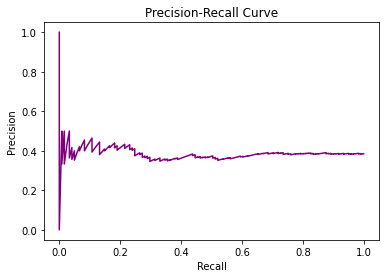

31: Out-of-bag score estimate: 0.524
31: Mean accuracy score: 0.532
31: Recall: 0.444


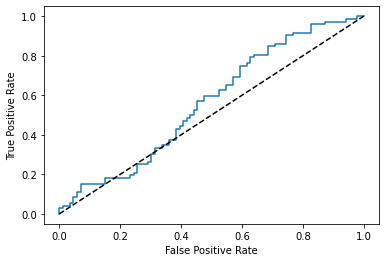

[0.18125241 0.21651568 0.23824138 0.23987299 0.2545897  0.2644281
 0.2659719  0.26774478 0.26982211 0.27212348 0.28111493 0.28143929
 0.28155461 0.28172674 0.29176383 0.29473082 0.29706237 0.30700632
 0.31193757 0.31286442 0.31291133 0.31450373 0.31505487 0.31591099
 0.31707182 0.31789843 0.31859433 0.32621767 0.32995749 0.33447547
 0.34044877 0.34047049 0.3411182  0.34541627 0.35290431 0.35361366
 0.35668373 0.36064845 0.36511028 0.36555561 0.36763992 0.36964049
 0.37055222 0.37818573 0.3799098  0.37995262 0.38497389 0.3850663
 0.385979   0.39029665 0.39173159 0.40483562 0.40859744 0.41306336
 0.41464805 0.41920458 0.42036555 0.42207228 0.42276759 0.4269015
 0.43235923 0.43251743 0.43266917 0.43313399 0.43359773 0.43581364
 0.43631883 0.43681182 0.43942894 0.44126652 0.44518102 0.44644249
 0.44907312 0.44993359 0.45649681 0.45665888 0.46647141 0.46759531
 0.46793654 0.46864995 0.46895469 0.46970478 0.47230156 0.4798902
 0.4810246  0.48209432 0.48997952 0.49253787 0.49489177 0.49960662

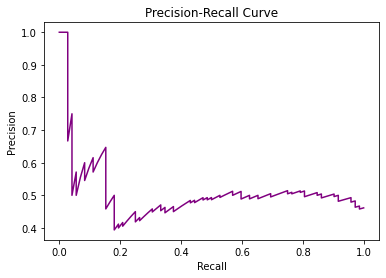

36: Out-of-bag score estimate: 0.548
36: Mean accuracy score: 0.542
36: Recall: 0.717


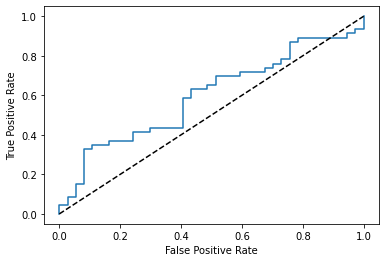

[0.14676516 0.17314567 0.20896493 0.25681811 0.27536564 0.30084558
 0.3101896  0.34412528 0.34761991 0.37976368 0.381559   0.39056571
 0.40167767 0.42458008 0.42628991 0.42711419 0.44011323 0.44284876
 0.44328967 0.44744993 0.46223504 0.47736315 0.47985665 0.49548433
 0.49857576 0.50890637 0.51260593 0.52085029 0.52749653 0.5322426
 0.53796129 0.53972399 0.54068661 0.54271329 0.55064757 0.55614067
 0.56039198 0.56516009 0.56528519 0.56687968 0.57308667 0.57704926
 0.57787006 0.5795037  0.58168245 0.58499181 0.5926117  0.59340565
 0.59993297 0.60163873 0.6070137  0.60871725 0.60873358 0.62211721
 0.62214716 0.62301541 0.62439821 0.64213501 0.65616103 0.66066009
 0.66694448 0.66856698 0.66866007 0.6706849  0.67143163 0.67663324
 0.70695234 0.71878704 0.72324396 0.72621449 0.73884488 0.74705319
 0.74885222 0.75328013 0.76044176 0.76623996 0.76792896 0.76884132
 0.78462346 0.78937522 0.81552619 0.82882784 0.88017484]


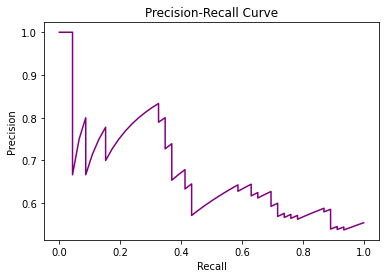

41: Out-of-bag score estimate: 0.616
41: Mean accuracy score: 0.71
41: Recall: 0.886


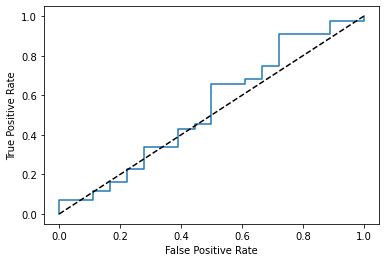

[0.20771776 0.25707914 0.3109942  0.40404875 0.40563472 0.40651537
 0.43298941 0.4456929  0.44739801 0.49021726 0.50801611 0.51908333
 0.52744172 0.52970686 0.53018435 0.53671515 0.56847857 0.5687207
 0.58764715 0.58819721 0.59475451 0.61388278 0.62836195 0.63552219
 0.64706138 0.65250717 0.66559697 0.66847031 0.67125946 0.67210421
 0.68796147 0.69162404 0.70170658 0.70322037 0.71267224 0.71411974
 0.71974858 0.73491801 0.73983532 0.74031835 0.74105595 0.74297507
 0.74966331 0.75975003 0.76114193 0.76171747 0.76227083 0.77473763
 0.77845268 0.78079724 0.78087843 0.79157216 0.81976428 0.83113934
 0.83227056 0.84115736 0.84541829 0.85161648 0.8534761  0.87071807
 0.9134387  0.91364231]


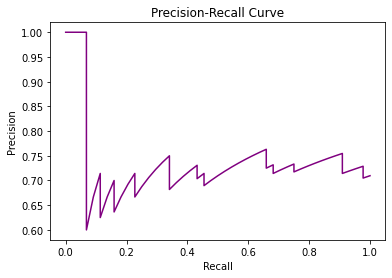

46: Out-of-bag score estimate: 0.668
46: Mean accuracy score: 0.66
46: Recall: 0.861


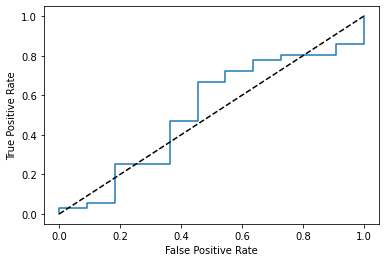

[0.38107889 0.42151996 0.45064103 0.45947826 0.48455423 0.51384444
 0.52300429 0.52648764 0.53751852 0.56777778 0.57701431 0.57902565
 0.6        0.61260452 0.62688095 0.63984062 0.652      0.65328889
 0.6615243  0.67404116 0.68232363 0.69728571 0.71316087 0.735
 0.74163806 0.746      0.75414683 0.76390641 0.77616667 0.78121319
 0.78728974 0.80687216 0.81808432 0.82173462 0.824      0.83332308
 0.8403     0.84589793 0.89742857 0.91786667 0.93645503 0.938
 0.942      0.95196429 0.952      0.9795     0.99      ]


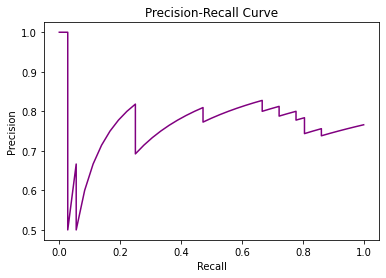

51: Out-of-bag score estimate: 0.729
51: Mean accuracy score: 0.808
51: Recall: 0.952


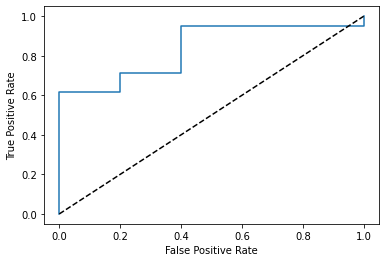

[0.338      0.392      0.544      0.57355556 0.6046125  0.60917917
 0.6536875  0.65631895 0.7075     0.7173125  0.718      0.72183577
 0.726      0.73144921 0.74551895 0.788      0.80444474 0.81288704
 0.85       0.866      0.93274886 0.94133333 0.9612     0.976
 0.98       0.99      ]


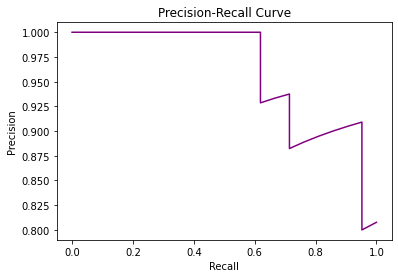

56: Out-of-bag score estimate: 0.723
56: Mean accuracy score: 0.625
56: Recall: 0.75


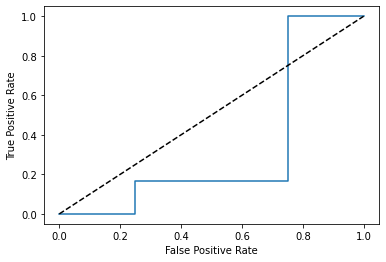

[0.442      0.4915     0.494      0.574      0.584      0.60071111
 0.614      0.7        0.718      0.798      0.82377778 0.856
 0.89       0.894     ]


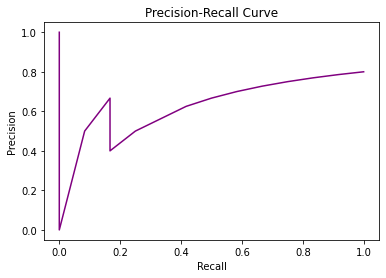

In [20]:
rf_xgboost_evaluate(clean_test_df_dict_force_simple, models_force_simple)

1: Out-of-bag score estimate: 0.616
1: Mean accuracy score: 0.616
1: Recall: 0.0769


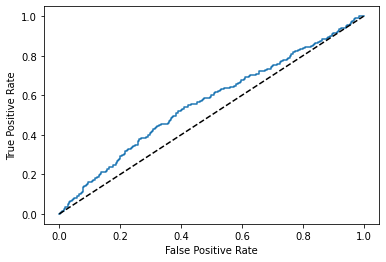

[0.23163109 0.23186219 0.23382061 0.23479135 0.2359958  0.23695149
 0.23726983 0.23804665 0.23822693 0.24022782 0.24240383 0.24298503
 0.24348683 0.24358183 0.24521188 0.2455498  0.24650338 0.24682408
 0.24871551 0.24910826 0.24930085 0.24942836 0.24946936 0.24970288
 0.25127343 0.25228297 0.25282618 0.25316649 0.25399983 0.2541505
 0.25417325 0.25423537 0.2562361  0.25718414 0.25762685 0.25859973
 0.25928968 0.2602785  0.26111177 0.26114075 0.26133528 0.26310455
 0.26446018 0.26531492 0.26593808 0.26629836 0.26664659 0.26710261
 0.26781543 0.26801908 0.26941022 0.26950693 0.26958533 0.27058034
 0.2713691  0.27177358 0.27184641 0.2722669  0.27236214 0.27236809
 0.2725468  0.27302115 0.27309002 0.27311249 0.27347872 0.27422204
 0.27484041 0.27490628 0.27554069 0.27604982 0.27704325 0.27759581
 0.27799754 0.27907384 0.27909451 0.27913438 0.27979827 0.28093784
 0.2812743  0.28147168 0.28158034 0.28166549 0.28270144 0.28379203
 0.28389964 0.28456639 0.28533528 0.2853445  0.28568577 0.28649

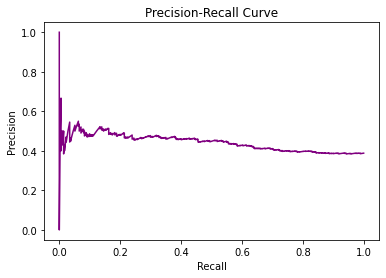

6: Out-of-bag score estimate: 0.614
6: Mean accuracy score: 0.613
6: Recall: 0.0809


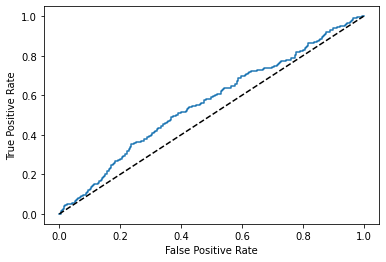

[0.14445037 0.15700239 0.16526732 0.16673265 0.17400804 0.18693417
 0.19839015 0.19921503 0.21290893 0.21496627 0.22256742 0.22304186
 0.22720876 0.22753691 0.23154469 0.23471876 0.24228651 0.24302911
 0.24443594 0.24581951 0.24680223 0.2528827  0.25394489 0.25506514
 0.25532873 0.25836238 0.25928735 0.2596721  0.26059383 0.26134172
 0.26156564 0.26186192 0.26188162 0.26393906 0.26422114 0.26483711
 0.2651375  0.26517518 0.26569152 0.26599799 0.26615382 0.26676921
 0.26706969 0.26723738 0.26808114 0.26810267 0.26868617 0.26955789
 0.2701983  0.27065844 0.27172381 0.27210117 0.27258317 0.27346802
 0.2750855  0.27532403 0.27542772 0.27589783 0.27615727 0.27674475
 0.27684269 0.27713963 0.27831337 0.27869292 0.27876729 0.27896096
 0.27912563 0.27914015 0.2800885  0.28016952 0.28031368 0.28040163
 0.28040432 0.28043032 0.28092745 0.28106886 0.28184211 0.28192754
 0.28203127 0.28210544 0.28274052 0.28312763 0.28367135 0.28368407
 0.28372619 0.2842179  0.28470758 0.28488515 0.28503089 0.2851

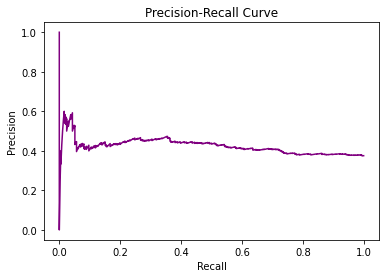

11: Out-of-bag score estimate: 0.61
11: Mean accuracy score: 0.619
11: Recall: 0.0383


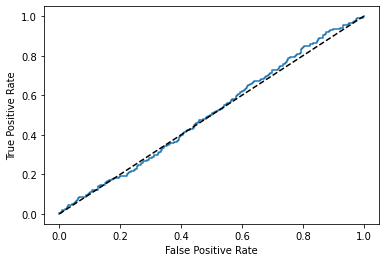

[0.16421274 0.2225544  0.22464256 0.22623185 0.23043096 0.23326109
 0.23452009 0.23551971 0.2365744  0.2367598  0.23684003 0.23818409
 0.24094853 0.2445934  0.24516486 0.24530173 0.24763226 0.24838332
 0.25039268 0.25048485 0.25147496 0.25277833 0.25629476 0.25712768
 0.25863565 0.26185851 0.26240724 0.2632122  0.26373809 0.26634269
 0.26652489 0.26731312 0.2682036  0.26930574 0.26937578 0.27276678
 0.27319377 0.27338792 0.27378442 0.27573828 0.27575125 0.27579872
 0.27780549 0.27787043 0.27866721 0.27903126 0.28016762 0.28062577
 0.28088025 0.28209431 0.28273448 0.28406853 0.28420709 0.28538654
 0.28554321 0.28592977 0.28692445 0.28762274 0.2883597  0.28872725
 0.28968778 0.29000414 0.2903343  0.2903468  0.29049383 0.29133619
 0.29138715 0.29156386 0.29320833 0.29321314 0.29323767 0.29328693
 0.29377324 0.29516921 0.29526155 0.29556911 0.29619482 0.29651643
 0.29657167 0.29665728 0.29712894 0.29723882 0.2978516  0.29793583
 0.29803117 0.29829704 0.29845418 0.29850742 0.29862451 0.2989

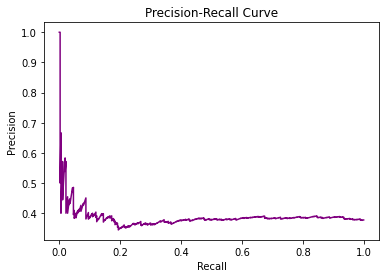

16: Out-of-bag score estimate: 0.607
16: Mean accuracy score: 0.619
16: Recall: 0.102


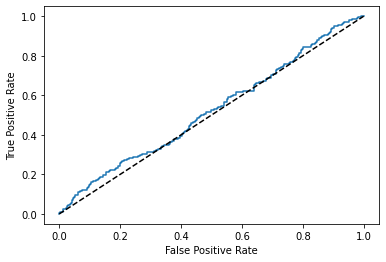

[0.18783114 0.19462484 0.19918115 0.19998812 0.2029921  0.2033059
 0.20485637 0.20505707 0.20521589 0.20637177 0.20743863 0.20772111
 0.20853211 0.20947438 0.20956406 0.20961647 0.20962262 0.21241233
 0.21728795 0.21753013 0.21869817 0.21894283 0.22412013 0.22559046
 0.22639547 0.22726218 0.22871571 0.22920052 0.23045979 0.23109183
 0.2314723  0.23327892 0.23400785 0.23475803 0.23492277 0.23523376
 0.23761076 0.23769806 0.23775925 0.23891263 0.24019401 0.24167411
 0.24221801 0.24227581 0.24347605 0.24393642 0.24584512 0.24643412
 0.24650056 0.24674253 0.24681437 0.24805091 0.24838051 0.25090302
 0.25162561 0.25201456 0.25290841 0.25304971 0.25655982 0.25679622
 0.25687466 0.25696004 0.25777356 0.25832311 0.25876121 0.25959033
 0.26000288 0.26027319 0.26083479 0.26094565 0.26158923 0.26182229
 0.26223054 0.26308454 0.26415267 0.26426905 0.26509239 0.26604876
 0.26791675 0.26824788 0.26857745 0.26878    0.26892299 0.26899108
 0.26977475 0.2699259  0.26998813 0.27029319 0.27153188 0.27232

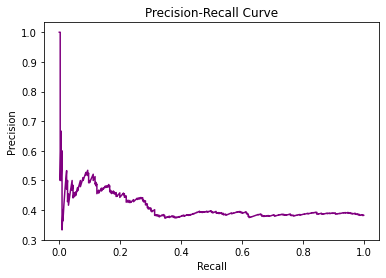

21: Out-of-bag score estimate: 0.625
21: Mean accuracy score: 0.631
21: Recall: 0.253


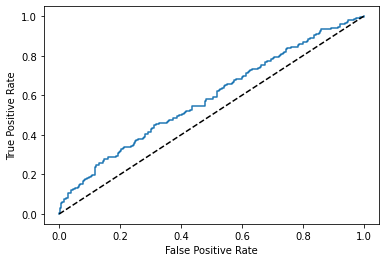

[0.14502831 0.14662453 0.14801725 0.14849862 0.14933755 0.15124104
 0.15481424 0.16039026 0.16722238 0.16933056 0.17344514 0.17362889
 0.17746119 0.17948173 0.1855892  0.18774502 0.19157615 0.19185016
 0.19294591 0.19640194 0.19901306 0.20138279 0.20214807 0.20227333
 0.20231116 0.20306777 0.20310357 0.20359781 0.20464631 0.2060007
 0.20604023 0.20708759 0.20925252 0.21120801 0.21251601 0.21367363
 0.22123378 0.22124033 0.22272582 0.22314216 0.22517197 0.22517799
 0.22655061 0.22704159 0.2289452  0.22919154 0.22923865 0.22940742
 0.2294414  0.2299674  0.23092619 0.23204136 0.23346201 0.23483229
 0.23794081 0.23795496 0.23860309 0.23952052 0.24093049 0.24196
 0.24340476 0.24414136 0.24485518 0.24590836 0.24659734 0.24661561
 0.24857739 0.2493928  0.25066826 0.25070153 0.25093106 0.25106326
 0.25159238 0.25164948 0.25197282 0.25407415 0.25434879 0.25510499
 0.2556846  0.2564022  0.2580692  0.25873241 0.25874167 0.25921527
 0.26012278 0.26018593 0.2613977  0.26147179 0.26195918 0.26211081

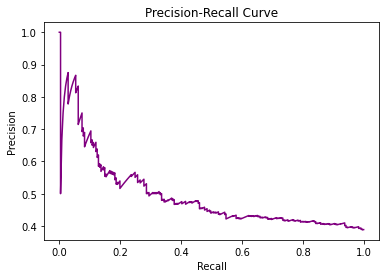

26: Out-of-bag score estimate: 0.64
26: Mean accuracy score: 0.589
26: Recall: 0.256


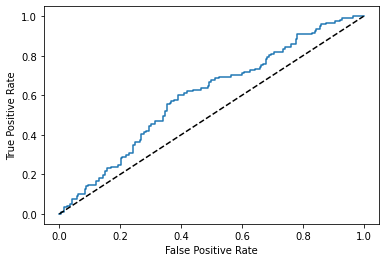

[0.15291965 0.1769136  0.18343703 0.19043668 0.19224017 0.19582077
 0.19708172 0.20985075 0.21091058 0.21260257 0.21306764 0.21801647
 0.2181929  0.22261981 0.22314411 0.22612599 0.22633601 0.23102809
 0.23231356 0.2330033  0.23364006 0.23536133 0.23569582 0.23817699
 0.23898264 0.24034419 0.24276224 0.24301441 0.24351251 0.24694314
 0.24744189 0.2479463  0.25202522 0.25447821 0.25494196 0.25524989
 0.25559075 0.25890838 0.26180087 0.26293898 0.26294592 0.26429403
 0.26504578 0.26565549 0.26650043 0.26846185 0.2698181  0.27087024
 0.27247929 0.2731769  0.27366432 0.27468053 0.27524277 0.27580907
 0.27659987 0.27944885 0.27951425 0.27959972 0.27976611 0.28020312
 0.28098743 0.28568386 0.2875801  0.28785374 0.28889645 0.28946749
 0.29107587 0.29505543 0.29717364 0.30016259 0.30207024 0.30234805
 0.30289366 0.30291967 0.30391888 0.30624109 0.30631093 0.3081719
 0.30845486 0.30870498 0.30944188 0.30944898 0.30964192 0.31028479
 0.31046124 0.31119741 0.31136609 0.31275231 0.31427388 0.31430

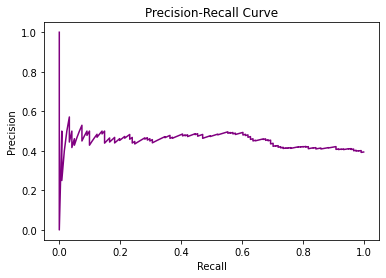

31: Out-of-bag score estimate: 0.621
31: Mean accuracy score: 0.582
31: Recall: 0.472


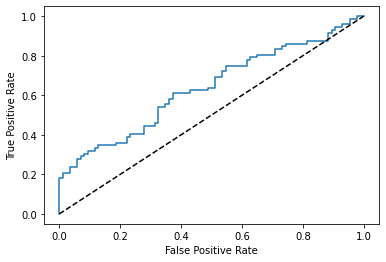

[0.16792001 0.17152403 0.18460735 0.18543894 0.18837843 0.18950332
 0.21977471 0.22009361 0.22604662 0.22851677 0.23267786 0.23308165
 0.24182121 0.24802938 0.24969686 0.25035284 0.25183693 0.25984761
 0.26028376 0.26230672 0.26643996 0.26688841 0.28228569 0.28323534
 0.28742798 0.29058567 0.29241604 0.30050809 0.30381597 0.30482008
 0.30702908 0.31102708 0.31107963 0.31566203 0.31596953 0.32896988
 0.33259954 0.33435029 0.33671571 0.33849565 0.34026571 0.34216587
 0.34873445 0.35444015 0.3560212  0.35630224 0.35783456 0.3587571
 0.37014112 0.37363262 0.38057006 0.38584261 0.38616639 0.38926647
 0.39242063 0.39413603 0.39657472 0.39851654 0.40440465 0.40505993
 0.40617768 0.40919963 0.41095505 0.42937984 0.4334756  0.43592215
 0.43744163 0.43916048 0.44128689 0.44443046 0.44470472 0.45100102
 0.45213693 0.45234159 0.45637005 0.45637641 0.46161549 0.46272934
 0.46292508 0.46702874 0.47068828 0.47262662 0.47633573 0.47756778
 0.48162018 0.48400935 0.48684598 0.48955048 0.4916499  0.49213

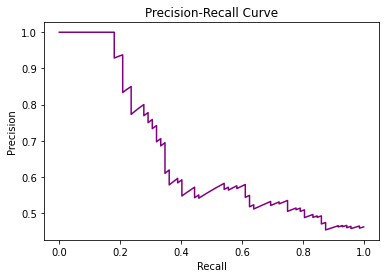

36: Out-of-bag score estimate: 0.638
36: Mean accuracy score: 0.711
36: Recall: 0.739


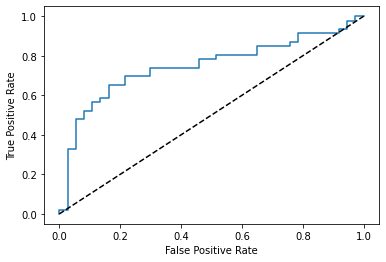

[0.22889476 0.25291253 0.25978095 0.25993641 0.264      0.26669767
 0.28891897 0.30558139 0.30590811 0.30876531 0.30996027 0.31492927
 0.32379522 0.32906167 0.34600093 0.36167026 0.37246123 0.373
 0.37936583 0.380845   0.38216088 0.38874615 0.40276876 0.41271496
 0.41565634 0.41631849 0.42624018 0.43053041 0.45701709 0.47045845
 0.47326772 0.47823333 0.49305152 0.49414075 0.49482249 0.49776051
 0.51185714 0.51904982 0.53990605 0.54075559 0.54224116 0.54236733
 0.55437579 0.57833119 0.5873505  0.59218225 0.59644444 0.60661731
 0.61284385 0.61927847 0.61963466 0.62793281 0.63627616 0.64126975
 0.65629835 0.67154456 0.67905556 0.70156953 0.70320956 0.71044215
 0.7228137  0.72986776 0.73511552 0.73538889 0.73647143 0.74388827
 0.7440998  0.7871029  0.792      0.81325685 0.81652079 0.84207914
 0.844      0.86037263 0.864      0.86966667 0.8830382  0.8985523
 0.908      0.91670902 0.93989474 0.95186667]


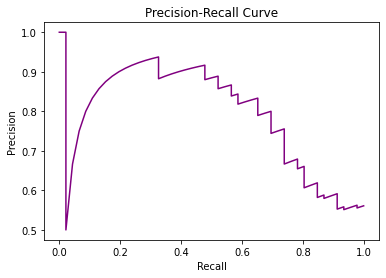

41: Out-of-bag score estimate: 0.708
41: Mean accuracy score: 0.71
41: Recall: 0.886


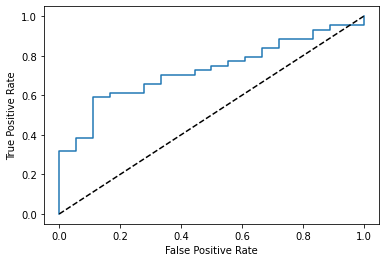

[0.19637252 0.284      0.28419939 0.32628889 0.34306566 0.35558828
 0.41550485 0.44108352 0.44895588 0.47055024 0.5079547  0.51264835
 0.51785    0.53122801 0.55084971 0.55285    0.57132867 0.57906818
 0.58130996 0.59571195 0.60858391 0.64692929 0.64819536 0.65287338
 0.65908063 0.66624548 0.66898889 0.67666802 0.682      0.68985714
 0.69414246 0.69873263 0.70802852 0.711      0.71150912 0.729
 0.73947932 0.76274779 0.76349206 0.76893333 0.78326667 0.79311654
 0.81602387 0.82318612 0.82610714 0.82654182 0.8333637  0.83807143
 0.84648088 0.85       0.85338703 0.86624476 0.87572018 0.88410366
 0.89185714 0.904      0.90699896 0.91169231 0.92322425 0.9375407
 0.94247576 0.94984985]


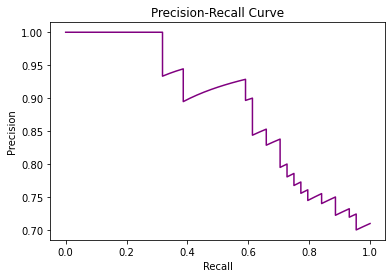

46: Out-of-bag score estimate: 0.726
46: Mean accuracy score: 0.66
46: Recall: 0.833


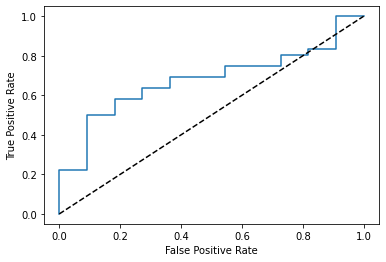

[0.308      0.37729405 0.38616667 0.398      0.44936364 0.49312088
 0.55933333 0.56287952 0.58904282 0.63384308 0.64592694 0.65350294
 0.66933333 0.67017054 0.68457838 0.687      0.68744612 0.7026295
 0.72352089 0.7429362  0.74672499 0.75901587 0.75985294 0.76669941
 0.77804216 0.784      0.78712771 0.788      0.79214886 0.808
 0.812      0.81533939 0.81857143 0.81967914 0.83933167 0.8499222
 0.85581182 0.85936077 0.91       0.916      0.91876027 0.92140454
 0.92373866 0.924      0.93806349 0.96542857]


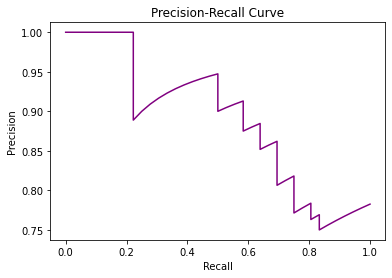

51: Out-of-bag score estimate: 0.771
51: Mean accuracy score: 0.615
51: Recall: 0.762


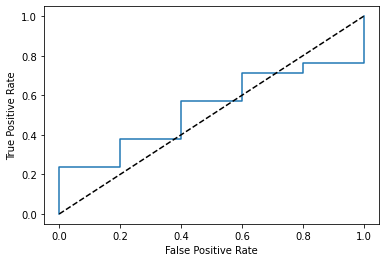

[0.27       0.352      0.376      0.432      0.528      0.54
 0.5728     0.586      0.74533333 0.77933333 0.78375    0.796
 0.804      0.81993103 0.83193103 0.85646667 0.878      0.886
 0.88793103 0.89968103 0.90733333 0.9148     0.922      0.926
 0.94      ]


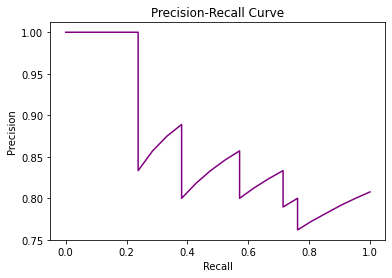

56: Out-of-bag score estimate: 0.745
56: Mean accuracy score: 0.562
56: Recall: 0.75


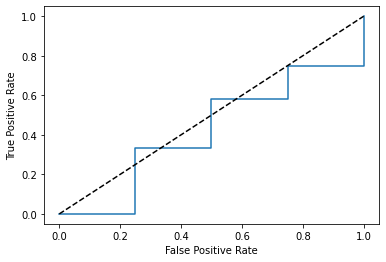

[0.358   0.446   0.494   0.548   0.612   0.624   0.628   0.652   0.752
 0.792   0.8     0.81775 0.892   0.9     0.934   0.964  ]


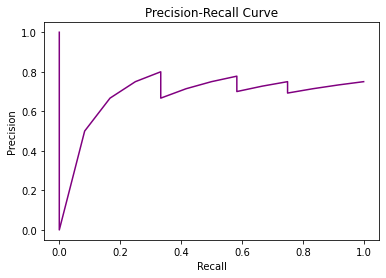

In [21]:
rf_xgboost_evaluate(clean_test_df_dict_dist, models_force_dist)

In [41]:

models = train_lr_model(clean_train_df_dict)
# pickle.dump(models, open("model_list_all_features.pkl", "wb"))

1: Out-of-bag score estimate: 0.609
1: Mean accuracy score: 0.61
1: Recall: 0.0513


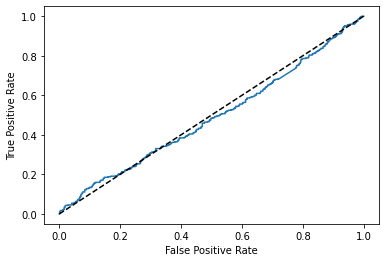

[0.2048156  0.20767583 0.2175177  0.22207462 0.22347004 0.22661669
 0.22945013 0.23069193 0.23190866 0.23510237 0.23517786 0.23596973
 0.23688386 0.24078606 0.24329442 0.24913169 0.24952459 0.25247373
 0.25283353 0.25382711 0.25404604 0.25681034 0.2598129  0.26021775
 0.26253889 0.26359367 0.26536792 0.26812433 0.26890286 0.26893395
 0.2694242  0.26943432 0.26949999 0.2710868  0.27213544 0.27409417
 0.27522828 0.27561399 0.27624847 0.27765868 0.27874795 0.27888633
 0.27892    0.2794122  0.27942019 0.27986896 0.28189136 0.28233037
 0.28265395 0.28274591 0.28361264 0.28411316 0.28455526 0.28467082
 0.28500342 0.28508123 0.28766166 0.28804144 0.28914731 0.28946147
 0.29064349 0.29133533 0.29172512 0.29184141 0.29226273 0.2925941
 0.29306998 0.29361043 0.29396668 0.29416054 0.29420949 0.29454479
 0.29478338 0.29497024 0.29570237 0.29579948 0.29627912 0.29655288
 0.29673816 0.29675748 0.29715958 0.29740586 0.29873881 0.29932068
 0.29953252 0.29970499 0.2998991  0.30154398 0.30174705 0.30252

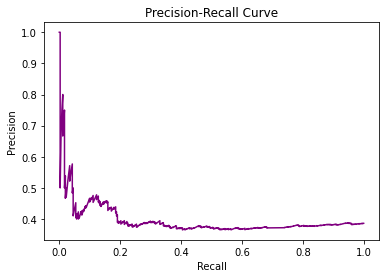

6: Out-of-bag score estimate: 0.611
6: Mean accuracy score: 0.613
6: Recall: 0.0458


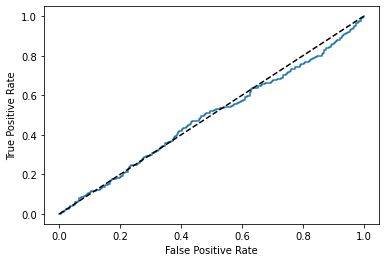

[0.1637784  0.18270644 0.18362603 0.18682921 0.1973786  0.19803338
 0.20563646 0.20770723 0.21022726 0.21794954 0.21828947 0.21927032
 0.21999636 0.22132587 0.22311786 0.22394715 0.22431632 0.22831917
 0.23022631 0.23056092 0.23344214 0.23351127 0.23416818 0.23467277
 0.23622831 0.2376629  0.23830473 0.24011024 0.24046529 0.24081314
 0.241335   0.24135539 0.24201888 0.24208013 0.24221019 0.24230888
 0.24294254 0.24350348 0.24366527 0.24564489 0.24662951 0.24695726
 0.24726322 0.24749584 0.25233929 0.25248383 0.25311993 0.25332572
 0.25392499 0.25400156 0.2541176  0.25427871 0.25438287 0.25493278
 0.25499756 0.25500152 0.25614768 0.25614849 0.25710178 0.25766955
 0.25793946 0.25879115 0.2589066  0.25897496 0.25997528 0.26075153
 0.26136204 0.26158736 0.26198567 0.26235813 0.26270428 0.26286587
 0.2629459  0.26490334 0.26491068 0.26502208 0.26572908 0.26656156
 0.2668282  0.26930154 0.27011594 0.2706533  0.27242686 0.27259402
 0.27306355 0.27320564 0.27328758 0.2734014  0.27435874 0.2748

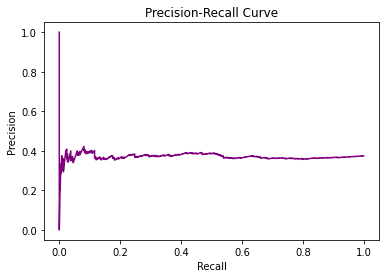

11: Out-of-bag score estimate: 0.603
11: Mean accuracy score: 0.61
11: Recall: 0.0738


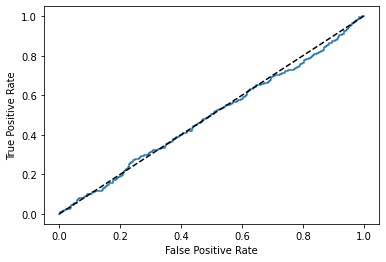

[0.23311175 0.23347597 0.23792181 0.23823786 0.238382   0.23844651
 0.23924536 0.23934034 0.23934487 0.24158335 0.24225525 0.24286717
 0.2430123  0.24425768 0.2454282  0.24589522 0.24885966 0.24916127
 0.24939888 0.25138594 0.2527731  0.25437915 0.25798105 0.25833515
 0.25852167 0.25955811 0.25965437 0.26404073 0.26409595 0.26437022
 0.26452635 0.26748492 0.26752322 0.26957983 0.27064389 0.27174507
 0.27205099 0.27323318 0.27411634 0.27417099 0.27594068 0.27694954
 0.27763185 0.2778336  0.27936822 0.2793897  0.27970405 0.28084176
 0.28113869 0.28165764 0.2824407  0.28263179 0.28276454 0.28292651
 0.2831602  0.28336345 0.28347191 0.28348891 0.28406366 0.28434937
 0.28538702 0.2861814  0.28642388 0.28765495 0.2879504  0.28837282
 0.28962494 0.29013818 0.29018435 0.29098702 0.29124982 0.29146272
 0.29153306 0.29216575 0.2922864  0.29243244 0.29265972 0.29271255
 0.29341325 0.29433283 0.29450291 0.29493003 0.29493473 0.29532754
 0.29558087 0.29597729 0.2961673  0.29626306 0.29680192 0.2970

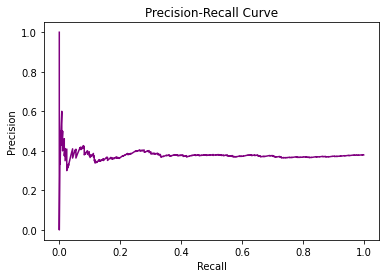

16: Out-of-bag score estimate: 0.605
16: Mean accuracy score: 0.601
16: Recall: 0.105


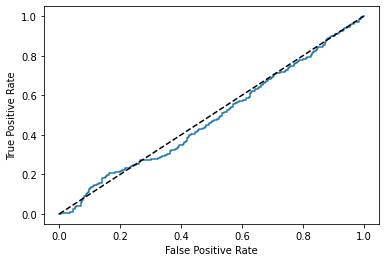

[0.1607979  0.176067   0.18952976 0.19133091 0.191594   0.19938139
 0.20407169 0.20449927 0.20483216 0.20497001 0.20852318 0.209299
 0.22040907 0.22223165 0.2226763  0.22663839 0.22765571 0.22942925
 0.22975441 0.23010021 0.23060104 0.23263383 0.23367557 0.23392792
 0.23408712 0.23434811 0.23572486 0.2361914  0.23662316 0.23804628
 0.2437591  0.24976018 0.25096517 0.2513266  0.25257831 0.25291389
 0.26013878 0.26162166 0.2616306  0.2616406  0.26245425 0.26367511
 0.2651612  0.26579293 0.26640022 0.26642879 0.266512   0.26700509
 0.26730817 0.26743167 0.26821426 0.26838014 0.26852658 0.2685574
 0.27025937 0.27026572 0.27047031 0.27174824 0.27385717 0.27393352
 0.27472559 0.27520962 0.27560949 0.27598464 0.2761061  0.27776928
 0.27839427 0.27850166 0.27906557 0.27938213 0.27949284 0.28126777
 0.2814612  0.28241208 0.28255086 0.28284484 0.28375786 0.28521813
 0.28526523 0.28566774 0.2858741  0.28605267 0.28677521 0.28776255
 0.2895816  0.29051024 0.29065333 0.29076942 0.29084877 0.2911293

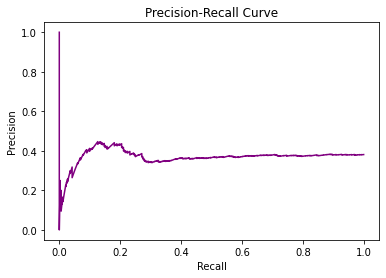

21: Out-of-bag score estimate: 0.595
21: Mean accuracy score: 0.595
21: Recall: 0.0788


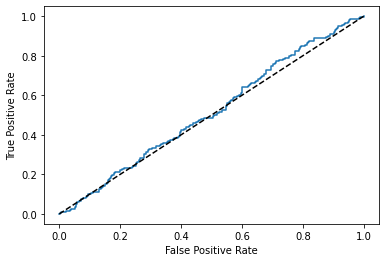

[0.1691233  0.19645602 0.1988536  0.20570872 0.20676356 0.21271925
 0.21687468 0.22254906 0.23078841 0.23107459 0.23124643 0.23146013
 0.2326816  0.23541586 0.23735154 0.24176126 0.24436401 0.24524722
 0.24564503 0.24811842 0.24939223 0.25048646 0.25065624 0.25122402
 0.25145926 0.25206123 0.25237415 0.25425415 0.25439471 0.2576912
 0.25836438 0.25970544 0.26081392 0.26142422 0.26227183 0.26348661
 0.26367182 0.2638977  0.26404143 0.26473273 0.26778707 0.26824554
 0.26895762 0.26983215 0.26995231 0.27236223 0.27253207 0.27278789
 0.27391345 0.27529131 0.27584067 0.2760451  0.27617617 0.27787406
 0.27788726 0.27865286 0.27993517 0.2806905  0.28204432 0.28241934
 0.2831858  0.283865   0.28389167 0.28542002 0.2870807  0.28715933
 0.28850608 0.2887468  0.29025615 0.29094105 0.29168588 0.29169365
 0.29182914 0.29209779 0.29224818 0.29265911 0.29312125 0.29438185
 0.29479385 0.29516291 0.29550299 0.29714199 0.29722422 0.29826166
 0.29871835 0.29895837 0.29919294 0.2996134  0.30039926 0.30075

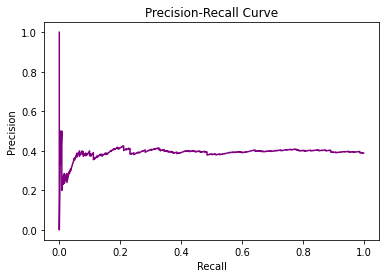

26: Out-of-bag score estimate: 0.555
26: Mean accuracy score: 0.583
26: Recall: 0.19


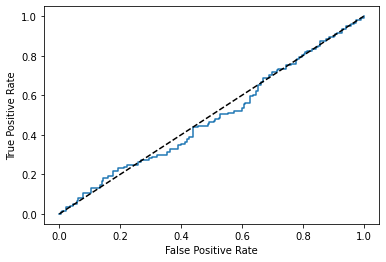

[0.16504596 0.17930151 0.18430264 0.19392904 0.19582163 0.20366566
 0.21039027 0.2118224  0.22184224 0.22718926 0.23015543 0.23061887
 0.23375516 0.23624225 0.23682535 0.23841139 0.25699554 0.26048327
 0.26436495 0.26462327 0.2659794  0.26682108 0.26861555 0.2686852
 0.2689821  0.26957756 0.27002032 0.27296959 0.27345568 0.27346102
 0.27351515 0.27550488 0.28226926 0.28267253 0.28361353 0.28442239
 0.28449774 0.28463523 0.28886545 0.28935239 0.29177972 0.29204396
 0.29354282 0.29369392 0.29524986 0.29648335 0.2974052  0.29834276
 0.2983645  0.29838082 0.29863723 0.30038253 0.30064938 0.3026306
 0.30340394 0.30402932 0.30410194 0.30492159 0.30509254 0.30515866
 0.3058567  0.30672026 0.30725835 0.30845563 0.30851897 0.30913539
 0.30993083 0.31187093 0.31538933 0.31565471 0.31757761 0.31894817
 0.31911065 0.32044416 0.32123431 0.32207072 0.32299712 0.32370643
 0.32649939 0.33025718 0.3303309  0.33086512 0.33090684 0.33091824
 0.33305086 0.333392   0.33506307 0.33541493 0.33565733 0.336273

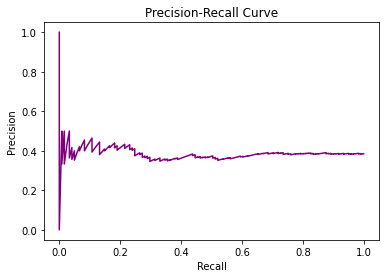

31: Out-of-bag score estimate: 0.524
31: Mean accuracy score: 0.532
31: Recall: 0.444


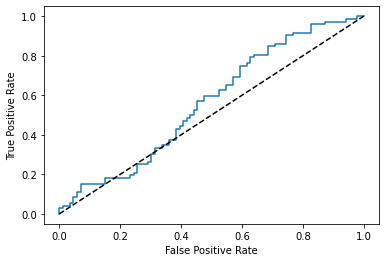

[0.18125241 0.21651568 0.23824138 0.23987299 0.2545897  0.2644281
 0.2659719  0.26774478 0.26982211 0.27212348 0.28111493 0.28143929
 0.28155461 0.28172674 0.29176383 0.29473082 0.29706237 0.30700632
 0.31193757 0.31286442 0.31291133 0.31450373 0.31505487 0.31591099
 0.31707182 0.31789843 0.31859433 0.32621767 0.32995749 0.33447547
 0.34044877 0.34047049 0.3411182  0.34541627 0.35290431 0.35361366
 0.35668373 0.36064845 0.36511028 0.36555561 0.36763992 0.36964049
 0.37055222 0.37818573 0.3799098  0.37995262 0.38497389 0.3850663
 0.385979   0.39029665 0.39173159 0.40483562 0.40859744 0.41306336
 0.41464805 0.41920458 0.42036555 0.42207228 0.42276759 0.4269015
 0.43235923 0.43251743 0.43266917 0.43313399 0.43359773 0.43581364
 0.43631883 0.43681182 0.43942894 0.44126652 0.44518102 0.44644249
 0.44907312 0.44993359 0.45649681 0.45665888 0.46647141 0.46759531
 0.46793654 0.46864995 0.46895469 0.46970478 0.47230156 0.4798902
 0.4810246  0.48209432 0.48997952 0.49253787 0.49489177 0.49960662

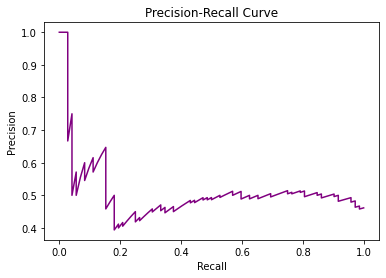

36: Out-of-bag score estimate: 0.548
36: Mean accuracy score: 0.542
36: Recall: 0.717


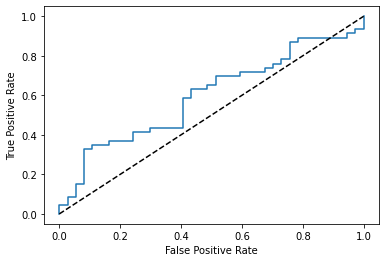

[0.14676516 0.17314567 0.20896493 0.25681811 0.27536564 0.30084558
 0.3101896  0.34412528 0.34761991 0.37976368 0.381559   0.39056571
 0.40167767 0.42458008 0.42628991 0.42711419 0.44011323 0.44284876
 0.44328967 0.44744993 0.46223504 0.47736315 0.47985665 0.49548433
 0.49857576 0.50890637 0.51260593 0.52085029 0.52749653 0.5322426
 0.53796129 0.53972399 0.54068661 0.54271329 0.55064757 0.55614067
 0.56039198 0.56516009 0.56528519 0.56687968 0.57308667 0.57704926
 0.57787006 0.5795037  0.58168245 0.58499181 0.5926117  0.59340565
 0.59993297 0.60163873 0.6070137  0.60871725 0.60873358 0.62211721
 0.62214716 0.62301541 0.62439821 0.64213501 0.65616103 0.66066009
 0.66694448 0.66856698 0.66866007 0.6706849  0.67143163 0.67663324
 0.70695234 0.71878704 0.72324396 0.72621449 0.73884488 0.74705319
 0.74885222 0.75328013 0.76044176 0.76623996 0.76792896 0.76884132
 0.78462346 0.78937522 0.81552619 0.82882784 0.88017484]


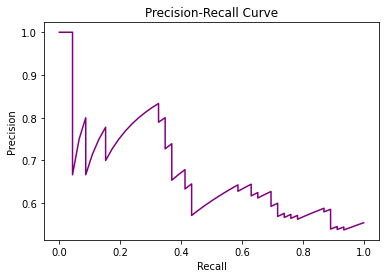

41: Out-of-bag score estimate: 0.616
41: Mean accuracy score: 0.71
41: Recall: 0.886


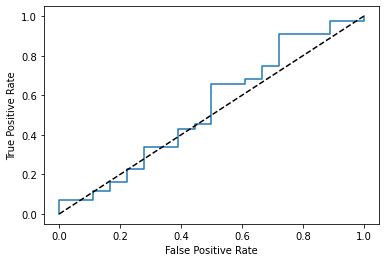

[0.20771776 0.25707914 0.3109942  0.40404875 0.40563472 0.40651537
 0.43298941 0.4456929  0.44739801 0.49021726 0.50801611 0.51908333
 0.52744172 0.52970686 0.53018435 0.53671515 0.56847857 0.5687207
 0.58764715 0.58819721 0.59475451 0.61388278 0.62836195 0.63552219
 0.64706138 0.65250717 0.66559697 0.66847031 0.67125946 0.67210421
 0.68796147 0.69162404 0.70170658 0.70322037 0.71267224 0.71411974
 0.71974858 0.73491801 0.73983532 0.74031835 0.74105595 0.74297507
 0.74966331 0.75975003 0.76114193 0.76171747 0.76227083 0.77473763
 0.77845268 0.78079724 0.78087843 0.79157216 0.81976428 0.83113934
 0.83227056 0.84115736 0.84541829 0.85161648 0.8534761  0.87071807
 0.9134387  0.91364231]


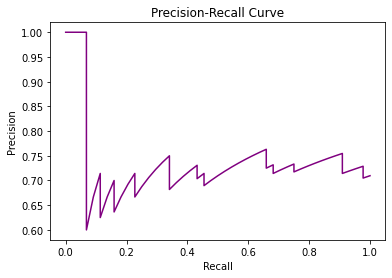

46: Out-of-bag score estimate: 0.668
46: Mean accuracy score: 0.66
46: Recall: 0.861


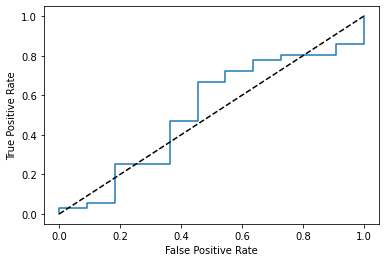

[0.38107889 0.42151996 0.45064103 0.45947826 0.48455423 0.51384444
 0.52300429 0.52648764 0.53751852 0.56777778 0.57701431 0.57902565
 0.6        0.61260452 0.62688095 0.63984062 0.652      0.65328889
 0.6615243  0.67404116 0.68232363 0.69728571 0.71316087 0.735
 0.74163806 0.746      0.75414683 0.76390641 0.77616667 0.78121319
 0.78728974 0.80687216 0.81808432 0.82173462 0.824      0.83332308
 0.8403     0.84589793 0.89742857 0.91786667 0.93645503 0.938
 0.942      0.95196429 0.952      0.9795     0.99      ]


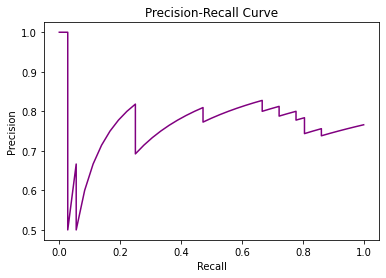

51: Out-of-bag score estimate: 0.729
51: Mean accuracy score: 0.808
51: Recall: 0.952


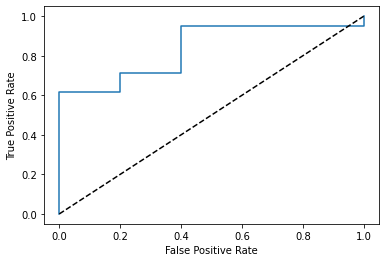

[0.338      0.392      0.544      0.57355556 0.6046125  0.60917917
 0.6536875  0.65631895 0.7075     0.7173125  0.718      0.72183577
 0.726      0.73144921 0.74551895 0.788      0.80444474 0.81288704
 0.85       0.866      0.93274886 0.94133333 0.9612     0.976
 0.98       0.99      ]


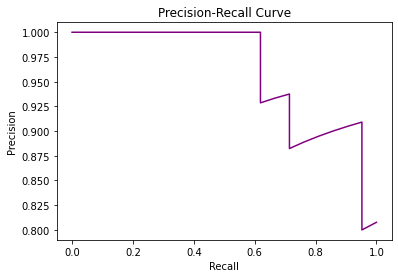

56: Out-of-bag score estimate: 0.723
56: Mean accuracy score: 0.625
56: Recall: 0.75


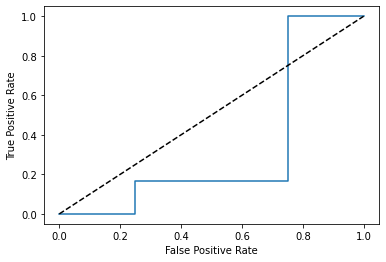

[0.442      0.4915     0.494      0.574      0.584      0.60071111
 0.614      0.7        0.718      0.798      0.82377778 0.856
 0.89       0.894     ]


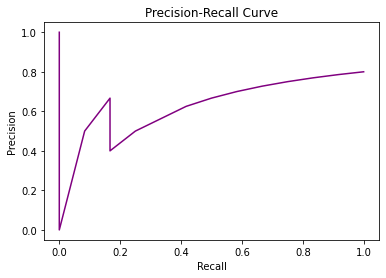

In [42]:
lr_evaluate(clean_test_df_dict_force_simple, models_force_simple)

1
[20:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
[20:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
11


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
16
[20:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
21
[20:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
26
[20:03:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the 

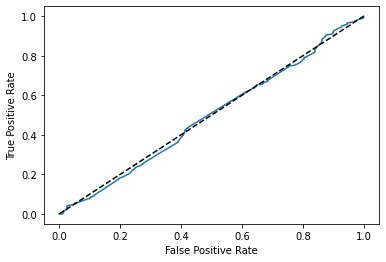

[0.23698941 0.24244335 0.24651997 0.24713966 0.24854478 0.25008994
 0.25268975 0.25838265 0.25902197 0.26046607 0.26060966 0.2612776
 0.26187995 0.26206467 0.26328042 0.26474506 0.2668613  0.26732925
 0.26872626 0.2720342  0.27209714 0.27275696 0.2729048  0.2735926
 0.27421278 0.2756546  0.27782512 0.27933997 0.28030083 0.2812587
 0.2834788  0.28349587 0.28472558 0.28699404 0.28748226 0.2876717
 0.2887111  0.2895732  0.29061326 0.29315662 0.29643786 0.2981626
 0.29844832 0.29850316 0.29954177 0.30002886 0.3002348  0.30106154
 0.30179092 0.30267543 0.30281445 0.30314517 0.30353338 0.30384985
 0.30492657 0.30538583 0.30646172 0.30717072 0.31061006 0.31097537
 0.3114831  0.31445348 0.31464356 0.31588945 0.31610405 0.31650662
 0.31679592 0.31698543 0.31730956 0.31841215 0.31893876 0.31910065
 0.3199839  0.32070974 0.32124233 0.32210973 0.32234815 0.322511
 0.32367557 0.32422972 0.32445917 0.32553682 0.32698548 0.33055678
 0.33291283 0.33437616 0.3351016  0.33548898 0.33590415 0.33598787
 0

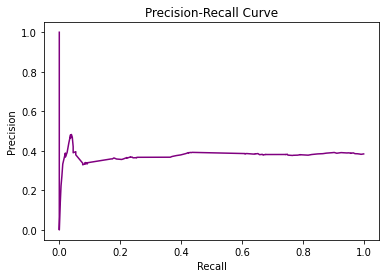

6: Mean accuracy score: 0.626
6: Recall: 0.0


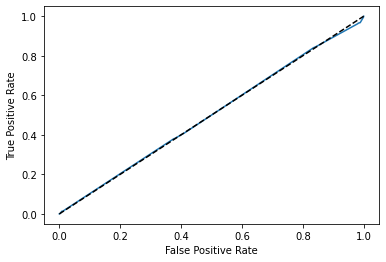

[0.25370538 0.25951377 0.2691606  0.2760951  0.29606035 0.30464438
 0.31479004 0.34011376 0.34529722 0.3496886  0.42256746 0.4394731
 0.44171143 0.4972212 ]


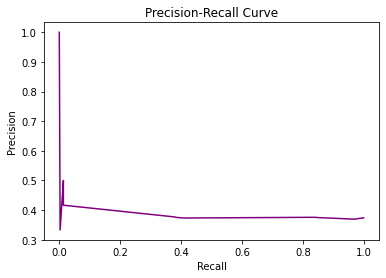

11: Mean accuracy score: 0.622
11: Recall: 0.0


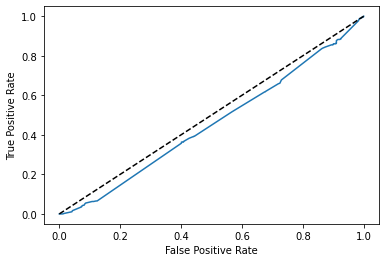

[0.17577878 0.18588327 0.20061307 0.20254749 0.20487984 0.21154131
 0.21177834 0.2122261  0.21621835 0.21691325 0.2180012  0.22592579
 0.22869591 0.22936404 0.2305756  0.23087254 0.23321943 0.23559323
 0.23919149 0.24431813 0.24582581 0.24701022 0.24701303 0.2475119
 0.25075254 0.2519556  0.25866026 0.25917453 0.25938645 0.26235852
 0.2627588  0.26375425 0.26448965 0.26645133 0.2671924  0.26749235
 0.26983118 0.27004948 0.27057812 0.27306965 0.2744656  0.2752197
 0.27528447 0.27834088 0.27850768 0.2810365  0.28180164 0.2838429
 0.2858923  0.2894214  0.29504308 0.29547644 0.29603466 0.30100107
 0.34309882 0.3460428  0.3490727  0.36030537 0.36641172 0.37462148
 0.38019428]


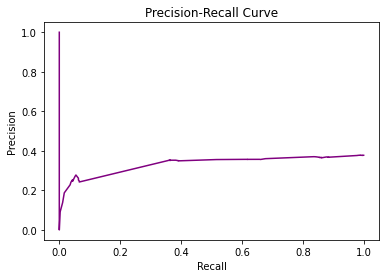

16: Mean accuracy score: 0.62
16: Recall: 0.00301


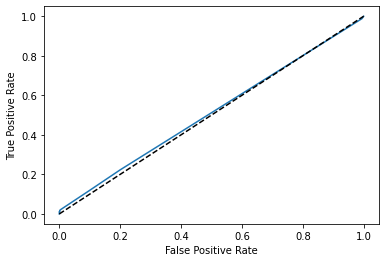

[0.25979275 0.3047777  0.3138251  0.32131958 0.36771387 0.37180486
 0.37579048 0.40623483 0.45577142 0.529795  ]


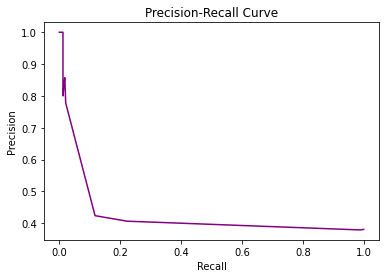

21: Mean accuracy score: 0.611
21: Recall: 0.0


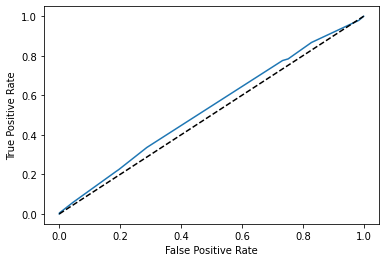

[0.29262576 0.3077835  0.3219647  0.32711622 0.33135742 0.34533072
 0.3672945  0.38234964 0.39099675 0.42698425]


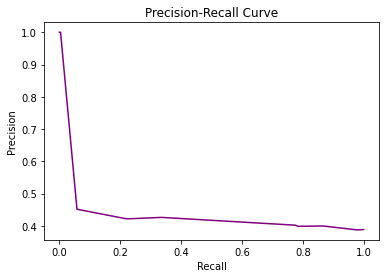

26: Mean accuracy score: 0.621
26: Recall: 0.0165


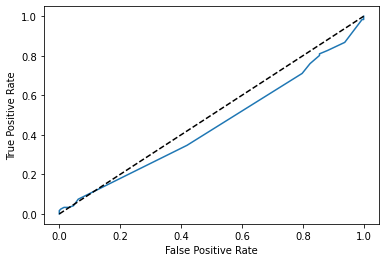

[0.27935797 0.28519318 0.28999725 0.30372286 0.3066641  0.33992985
 0.3515245  0.35469288 0.3635258  0.36674118 0.36715642 0.37038526
 0.41218457 0.4307245  0.43605536 0.4394693  0.5140982 ]


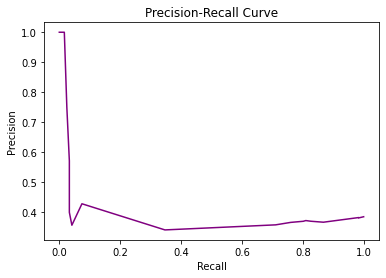

31: Mean accuracy score: 0.544
31: Recall: 0.0


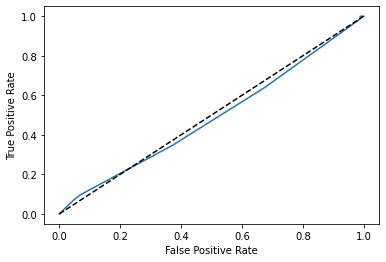

[0.28250462 0.31358892 0.32988203 0.33643937 0.34667623 0.3497575 ]


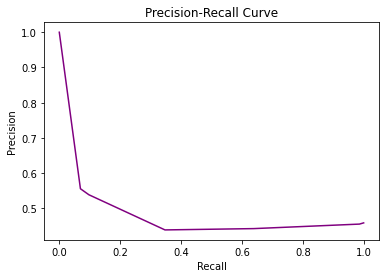

36: Mean accuracy score: 0.446
36: Recall: 0.0


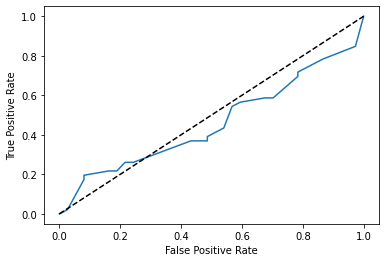

[0.15973696 0.19260801 0.2065055  0.22246724 0.23731385 0.29011214
 0.29060712 0.31144914 0.32718775 0.339527   0.34932905 0.35465938
 0.37897572 0.38775572 0.39738888 0.40080407 0.40138116 0.40252495
 0.44319412 0.46240416]


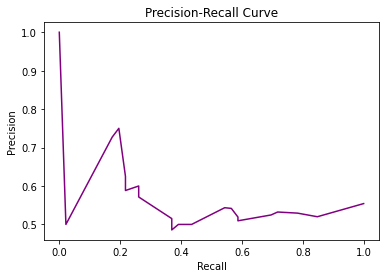

41: Mean accuracy score: 0.323
41: Recall: 0.0909


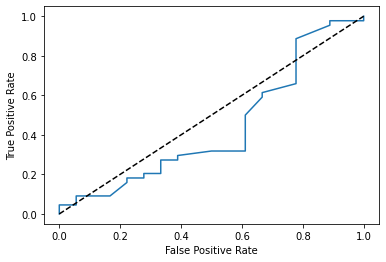

[0.09276446 0.10437538 0.14199421 0.15630582 0.17937571 0.20282723
 0.21453907 0.24220099 0.24350563 0.26488984 0.2752469  0.28319967
 0.29831937 0.30665675 0.31705543 0.34289858 0.35461554 0.35476062
 0.35704106 0.37540004 0.37788445 0.38084507 0.38334346 0.38902152
 0.3965579  0.4078826  0.41900763 0.41909823 0.4437393  0.44635278
 0.4597235  0.46679384 0.47438014 0.49760258 0.510717   0.57323575
 0.5758224  0.60130763 0.6062219 ]


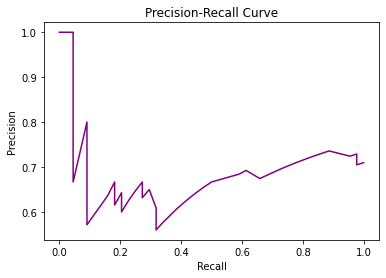

46: Mean accuracy score: 0.362
46: Recall: 0.167


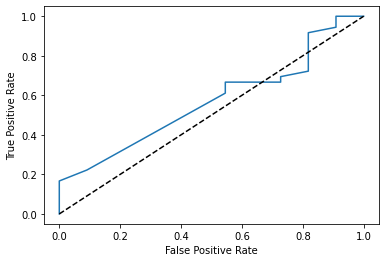

[0.29166958 0.29209527 0.38722983 0.41496807 0.41894326 0.4235005
 0.42399418 0.4255604  0.44571072 0.4472949  0.47439495 0.5340098
 0.5626087  0.68498206 0.69349456 0.80293185]


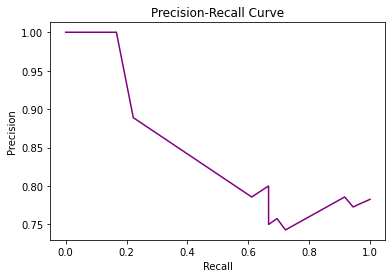

51: Mean accuracy score: 0.615
51: Recall: 0.762


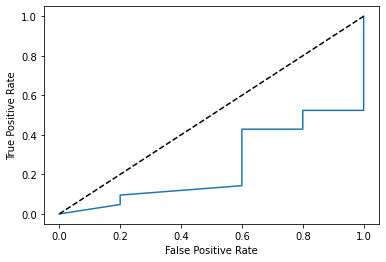

[0.30827036 0.4467383  0.46976843 0.48576525 0.5245968  0.54248947
 0.5437456  0.54429364 0.5874193  0.6161352  0.62450826 0.6754275
 0.6787472  0.6953972  0.69985205 0.7116562  0.71296126 0.713146
 0.74386096 0.77587724]


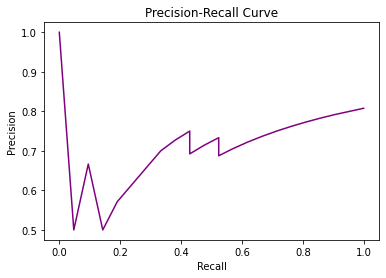

56: Mean accuracy score: 0.188
56: Recall: 0.0


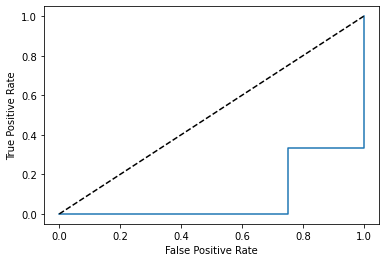

[0.09271906 0.13103326 0.14224783 0.14616357 0.15220226 0.15605865
 0.1714252  0.20165396 0.23696932 0.2597887  0.26967543 0.29522496
 0.357367   0.36548463 0.520147  ]


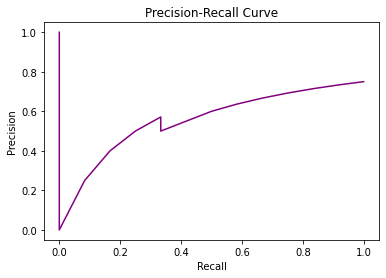

In [55]:
model3 = train_xgboost_model(clean_train_df_dict)
rf_xgboost_evaluate(clean_test_df_dict_dist, model3,True)